# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split
import hvplot.pandas
import holoviews as hv
from holoviews import opts
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")
dataset = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")


# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
dataset.sample(5)

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1583,1,8000,92487.0,113947.0,8.0,0.0,3.0,151.817389,0.0,19.0,26.457524
1102,0,9400,53244.0,62245.0,23.0,0.0,0.0,276.787744,3.0,28.0,37.821852
1191,0,23600,69846.0,189234.0,11.0,0.0,0.0,357.805062,0.0,17.0,30.564280
179,0,8700,93759.0,119459.0,24.0,0.0,0.0,138.091230,1.0,12.0,38.729711
1107,0,12100,105104.0,144712.0,13.0,0.0,0.0,129.518808,5.0,22.0,37.413775



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

Pregunta 1: El conjunto de datos es para el análisis de riesgo crediticio.
Pregunta 2: Variable Objetivo

TARGET: 1 = candidato con préstamo incumplido o con mora; 0 = candidato que paga su deuda y no tiene registro negativo (no se como saber qué es 0 y que es 1)

LOAN: Monto de solicitud de préstamo

MORTDUE: Monto adeudado de la hipoteca existente

VALUE: Valor actual del bien o propiedad

YOJ: Años es su trabajo actual

DEROG: Número de informes derogados o cancelados importantes

DELINQ: Número de lineas de crédito morosas

CLAGE: Antiguedad de la linea de crédito más antigua en meses

NINQ:Número de consultas crediticas recientes

CLNO: Número de líneas de crédito

DEBTINC: Entiendo que es la tasa Deuda/ingreso. Cuanto menor sea mas creible debe ser que va a poder pagar..



In [4]:
dataset[dataset['TARGET']==0].drop('TARGET', axis=1).describe().style.format("{:.2f}")

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1545.00,1545.00,1545.00,1545.00,1545.00,1545.00,1545.00,1545.00,1545.00,1545.00
mean,19319.55,76798.12,108209.45,9.17,0.10,0.19,186.32,1.03,21.75,33.46
std,11034.28,45233.45,54332.51,7.71,0.37,0.56,81.90,1.51,8.97,6.59
min,2400.00,5627.00,26140.00,0.00,0.00,0.00,0.49,0.00,3.00,4.03
25%,12200.00,49484.00,72189.00,3.00,0.00,0.00,121.30,0.00,16.00,29.04
50%,17100.00,68056.00,95329.00,7.00,0.00,0.00,182.17,1.00,21.00,34.68
75%,24200.00,94727.00,123582.00,14.00,0.00,0.00,238.70,2.00,27.00,38.73
max,89800.00,371003.00,471827.00,36.00,3.00,4.00,639.06,11.00,56.00,45.57


In [5]:
dataset[dataset['TARGET']==1].drop('TARGET', axis=1).describe().style.format("{:.2f}")

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,309.00,309.00,309.00,309.00,309.00,309.00,309.00,309.00,309.00,309.00
mean,18072.82,73905.72,102879.28,7.57,0.63,0.98,150.21,1.64,22.39,40.12
std,10786.67,50915.87,63807.98,6.58,1.43,1.76,92.67,2.23,11.87,16.33
min,1700.00,5900.00,21144.00,0.00,0.00,0.00,8.06,0.00,0.00,0.84
25%,10600.00,45351.00,66802.00,3.00,0.00,0.00,94.78,0.00,14.00,32.91
50%,16200.00,62264.00,86172.00,6.00,0.00,0.00,132.16,1.00,21.00,38.26
75%,22400.00,87979.00,122021.00,11.00,1.00,1.00,188.34,2.00,28.00,43.87
max,77400.00,399412.00,512650.00,41.00,10.00,10.00,1168.23,13.00,65.00,144.19


Del análisis vemos que aquellos que fueron asignados con TARGET=0 son los que se pagaron,  y se pagaron 1545 y no se pagaron 309 . A continuación estudiemos porcentualmente cuales son las medias que mas cambian entre el caso que paga y el que no

In [6]:
# Filtrar los subconjuntos de datos
data_0 = dataset[dataset['TARGET'] == 0].drop('TARGET', axis=1)
data_1 = dataset[dataset['TARGET'] == 1].drop('TARGET', axis=1)

# Calcular las medias
mean_0 = data_0.mean()
mean_1 = data_1.mean()

# Calcular la diferencia porcentual
percentage_difference = ((-mean_1 + mean_0) / mean_1) * 100
percentage_difference_abs=percentage_difference.abs()


# Formatear el resultado
percentage_difference_df = percentage_difference_abs.to_frame(name='Percentage Difference')
percentage_difference_df_sorted = percentage_difference_df.sort_values(by='Percentage Difference')



# Mostrar el resultado
percentage_difference_df_sorted

,Percentage Difference
CLNO,2.864576
MORTDUE,3.913629
VALUE,5.181001
LOAN,6.898379
DEBTINC,16.597813
YOJ,21.154833
CLAGE,24.037484
NINQ,37.598425
DELINQ,80.858086
DEROG,84.307692


De este análisis estadístico, da la impresión que los atributos que van desde DEBTINC en adelante son los que mas cambian de un caso al otro.

In [20]:
#HeatMap[tools=['hover'] colorbar=True width=500  height=500 toolbar='above', xrotation=45, yrotation=45]

corr=dataset.corr()
corr_long = corr.stack().reset_index()
corr_long.columns = ['X', 'Y', 'Value']

# Create the heatmap
heatmap = hv.HeatMap(corr_long).opts(cmap='Viridis', 
    colorbar=True, 
    width=500, 
    height=500, 
    toolbar='above', 
    xrotation=45, 
    yrotation=45,
    tools=['hover'])
    # Display the heatmap

heatmap


:HeatMap   [X,Y]   (Value)

En el anterior heat map también podemos ver que variables como DEROG, DELINQ;NINQ;DEBTINC; Clage parecen ser las más relacionadas con TARGET

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [25]:
from sklearn.linear_model import SGDClassifier

steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
         ('model', SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, random_state=0))]

pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SGDClassifier(random_state=0))])

In [29]:
def plot_roc(pipe, X_test, y_test, ax):
    plot_roc_curve(pipe, X_test, y_test, ax=ax)

def plot_proba(pipe, X_test, y_test, ax):
    proba = pipe.predict_proba(X_test)[:, 1]
    ax.hist(proba, bins=20)
    ax.set_title('Predicted Probabilities')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

def feature_importance(coef, feature_names, ax):
    importance = np.abs(coef)
    sorted_idx = np.argsort(importance)[::-1]
    ax.bar(range(len(sorted_idx)), importance[sorted_idx])
    ax.set_xticks(range(len(sorted_idx)))
    ax.set_xticklabels(np.array(feature_names)[sorted_idx], rotation=90)
    ax.set_title('Feature Importance')


c:\Users\Belen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


TypeError: inner() got multiple values for argument 'ax'

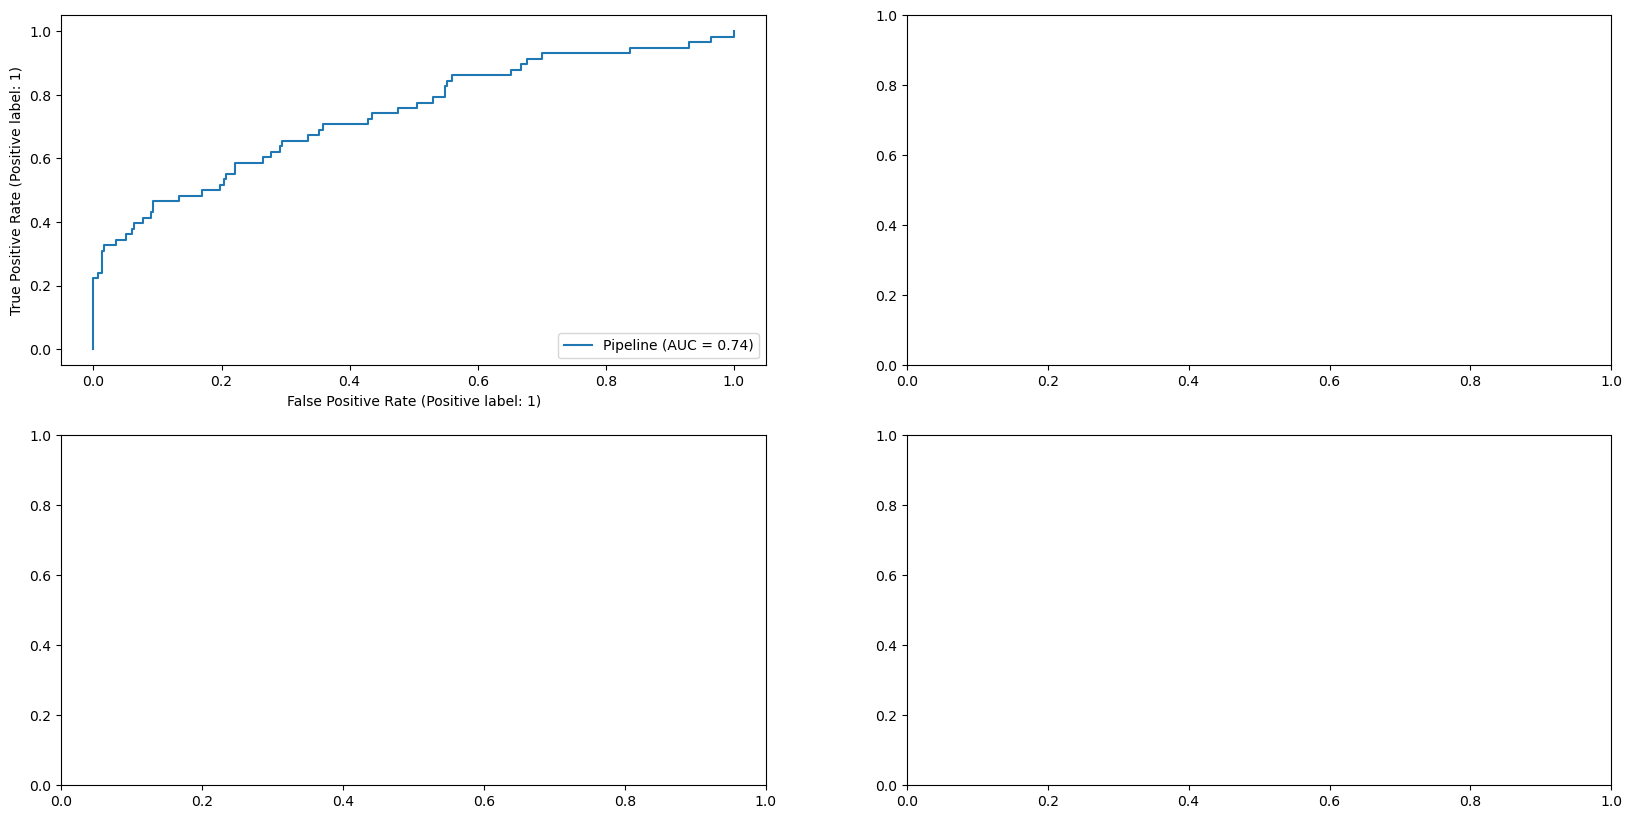

In [36]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


# Plot ROC curve
plot_roc(pipe, X_test, y_test, ax=ax1)

# Plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, normalize='true', ax=ax2)



# Plot feature importance
feature_importance(pipe.named_steps['model'].coef_[0], X.columns, ax=ax3)
# Plot predicted probabilities
plot_proba(pipe, X_test, y_test, ax=ax4)

# Adjust layout
plt.tight_layout()
plt.show()


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html